In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../data/processed/stimulus_cleaned.csv")  # Adjust path if needed
print(df.shape)
df["label"].value_counts()


(13557, 19)


label
spender    6592
debtor     4398
saver      2567
Name: count, dtype: int64

In [3]:
for col in ["J51_1", "J51_2", "J51_3"]:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)


In [4]:
X = df.drop(columns=["label"])
y = df["label"]

# Label encode the target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Report:
              precision    recall  f1-score   support

      debtor       0.49      0.44      0.46       880
       saver       0.00      0.00      0.00       513
     spender       0.55      0.79      0.65      1319

    accuracy                           0.53      2712
   macro avg       0.34      0.41      0.37      2712
weighted avg       0.42      0.53      0.46      2712



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


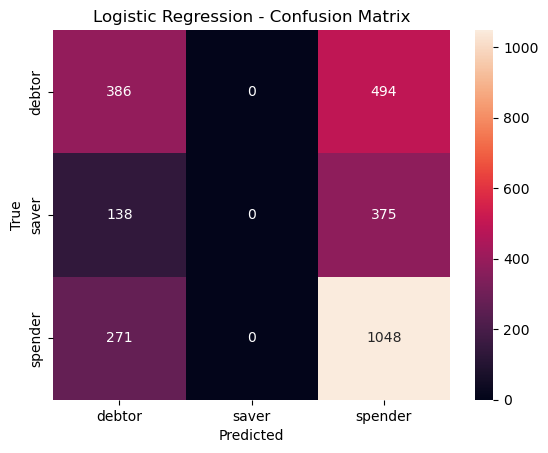

In [5]:
lr = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Random Forest Report:
              precision    recall  f1-score   support

      debtor       0.58      0.72      0.64       880
       saver       0.32      0.01      0.03       513
     spender       0.62      0.74      0.67      1319

    accuracy                           0.60      2712
   macro avg       0.50      0.49      0.45      2712
weighted avg       0.55      0.60      0.54      2712



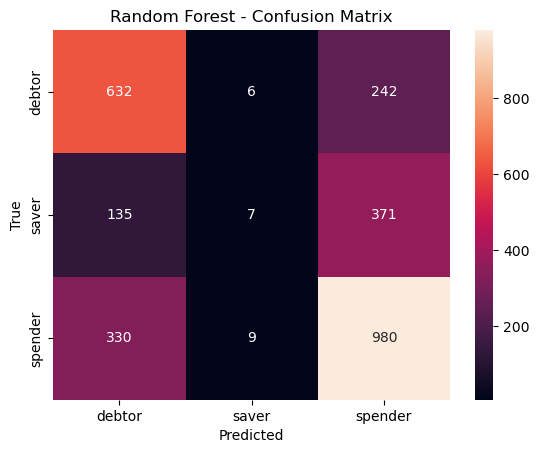

In [6]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:09:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Report:

              precision    recall  f1-score   support

      debtor       0.58      0.72      0.64       880
       saver       0.40      0.04      0.08       513
     spender       0.62      0.73      0.67      1319

    accuracy                           0.60      2712
   macro avg       0.53      0.50      0.46      2712
weighted avg       0.56      0.60      0.55      2712



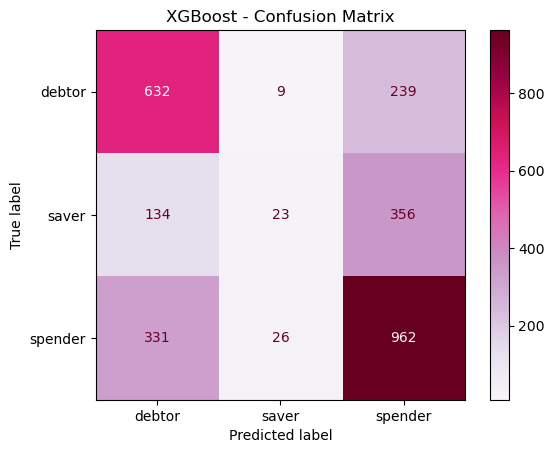

In [4]:
# --- Imports ---
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# --- Load your cleaned dataset ---
df_cleaned = pd.read_csv("../data/processed/stimulus_cleaned.csv")  # Adjust path if needed

# --- Split features and labels ---
X = df_cleaned.drop(columns=['label'])
y = df_cleaned['label']

# --- Stratified train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
joblib.dump(y_train, "../data/processed/y_train.pkl")

# --- Label encoding for multi-class XGBoost ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# --- Train XGBoost ---
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    learning_rate=0.1,
    max_depth=4,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train, y_train_enc)

# --- Evaluate ---
y_pred_enc = xgb.predict(X_test)
y_pred = le.inverse_transform(y_pred_enc)

# --- Classification report ---
print("XGBoost Report:\n")
print(classification_report(y_test, y_pred))

# --- Confusion matrix ---
conf_matrix = confusion_matrix(y_test, y_pred, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le.classes_)
disp.plot(cmap='PuRd')
plt.title("XGBoost - Confusion Matrix")
plt.show()


Random Forest (class_weight=balanced)
              precision    recall  f1-score   support

      debtor       0.56      0.75      0.64       880
       saver       0.29      0.35      0.32       513
     spender       0.70      0.48      0.57      1319

    accuracy                           0.54      2712
   macro avg       0.52      0.53      0.51      2712
weighted avg       0.58      0.54      0.55      2712



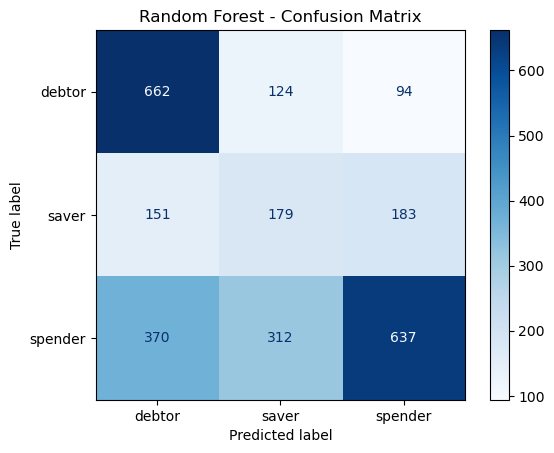

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',  # ⬅️ handles class imbalance
    random_state=42
)
rf_clf.fit(X_train, y_train)

# Predict
y_pred_rf = rf_clf.predict(X_test)

# Evaluation
print("Random Forest (class_weight=balanced)")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=rf_clf.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_clf.classes_)
disp_rf.plot(cmap="Blues")
plt.title("Random Forest - Confusion Matrix")
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [03:47:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost (with sample_weight)
              precision    recall  f1-score   support

      debtor       0.56      0.72      0.63       880
       saver       0.29      0.43      0.35       513
     spender       0.72      0.45      0.55      1319

    accuracy                           0.53      2712
   macro avg       0.53      0.53      0.51      2712
weighted avg       0.59      0.53      0.54      2712



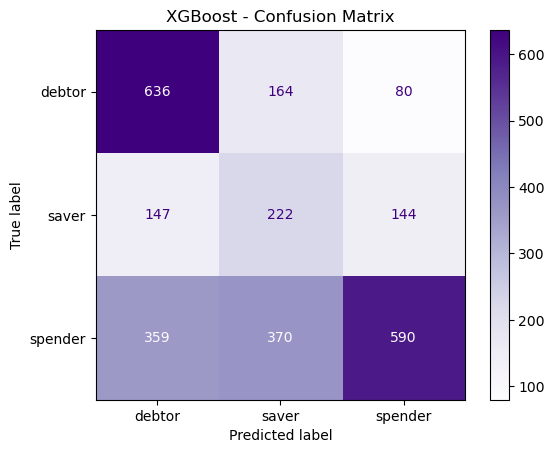

In [11]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 🔁 Step 1: Encode string labels into integers
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# 🔁 Step 2: Compute sample weights for class imbalance
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train_enc)

# ✅ Step 3: Train XGBoost with sample_weight
xgb_clf = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_clf.fit(X_train, y_train_enc, sample_weight=sample_weights)

# 🔍 Step 4: Predict and decode labels
y_pred_enc = xgb_clf.predict(X_test)
y_pred = le.inverse_transform(y_pred_enc)

# 📊 Step 5: Evaluate
print("XGBoost (with sample_weight)")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred, labels=le.classes_)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=le.classes_)
disp_xgb.plot(cmap="Purples")
plt.title("XGBoost - Confusion Matrix")
plt.show()



In [13]:
from sklearn.preprocessing import LabelEncoder

# Create label encoder and fit on full y
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)  # same encoder must be used

# Optionally print mapping
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'debtor': 0, 'saver': 1, 'spender': 2}


In [8]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# Initialize classifier
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# Grid search with 5-fold CV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit on encoded labels
grid_search.fit(X_train, y_train_encoded)

# Print best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
print("Best F1-score (cross-val, weighted):", grid_search.best_score_)

# Evaluate best model on test set
best_xgb = grid_search.best_estimator_
y_pred_best_encoded = best_xgb.predict(X_test)

# Metrics
f1 = f1_score(y_test_encoded, y_pred_best_encoded, average='weighted')
acc = accuracy_score(y_test_encoded, y_pred_best_encoded)
print("Test Accuracy:", acc)
print("Test F1-score (weighted):", f1)

# Optional: Convert predictions back to original class names
y_pred_best = le.inverse_transform(y_pred_best_encoded)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:20:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:20:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:20:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:20:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Best F1-score (cross-val, weighted): 0.5583400303888455
Test Accuracy: 0.5822271386430679
Test F1-score (weighted): 0.5484204020023601


In [9]:
from sklearn.dummy import DummyClassifier

# Majority class baseline
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train_encoded)
y_dummy = dummy_clf.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test_encoded, y_dummy))
print("Baseline F1-score (weighted):", f1_score(y_test_encoded, y_dummy, average='weighted'))


Baseline Accuracy: 0.4863569321533923
Baseline F1-score (weighted): 0.31828568271412777


In [10]:
from sklearn.utils.class_weight import compute_sample_weight

# Compute sample weights for training data
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_encoded)

# Train new XGBoost model with weights
xgb_weighted = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_weighted.fit(X_train, y_train_encoded, sample_weight=sample_weights)

# Evaluate
y_pred_weighted = xgb_weighted.predict(X_test)
print("Weighted XGBoost Accuracy:", accuracy_score(y_test_encoded, y_pred_weighted))
print("Weighted XGBoost F1-score (weighted):", f1_score(y_test_encoded, y_pred_weighted, average='weighted'))


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:22:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Weighted XGBoost Accuracy: 0.5232300884955752
Weighted XGBoost F1-score (weighted): 0.5284929492922426


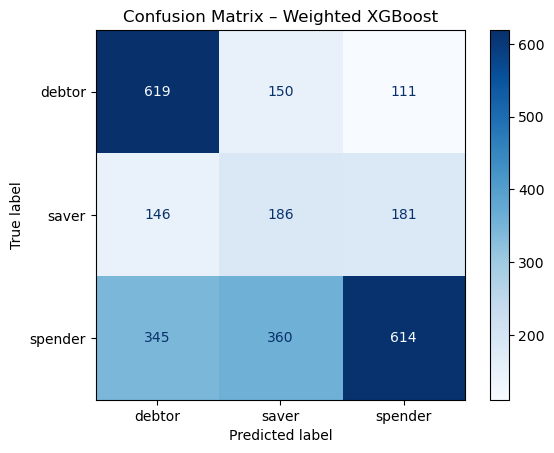

In [11]:
ConfusionMatrixDisplay.from_predictions(
    y_test_encoded, y_pred_weighted,
    display_labels=le.classes_, cmap='Blues'
)
plt.title("Confusion Matrix – Weighted XGBoost")
plt.show()

In [13]:
from sklearn.metrics import classification_report
import pandas as pd
import os

# Generate classification report
report = classification_report(
    y_test_encoded,
    y_pred_weighted,
    target_names=le.classes_,
    output_dict=True
)

# Convert to DataFrame
df_report = pd.DataFrame(report).transpose()

# Ensure save folder exists
os.makedirs("plots/modeling", exist_ok=True)

# Save as CSV
df_report.to_csv("plots/modeling/f1_per_class_weighted_xgb.csv", float_format="%.3f")

# Display in notebook
display(df_report[["precision", "recall", "f1-score"]].round(3))
print("✅ Saved: plots/modeling/f1_per_class_weighted_xgb.csv")


,precision,recall,f1-score
debtor,0.558,0.703,0.622
saver,0.267,0.363,0.308
spender,0.678,0.466,0.552
accuracy,0.523,0.523,0.523
macro avg,0.501,0.510,0.494
weighted avg,0.561,0.523,0.528


✅ Saved: plots/modeling/f1_per_class_weighted_xgb.csv


In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

# Create directory if it doesn't exist
os.makedirs("plots/modeling", exist_ok=True)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=le.classes_)

# Plot heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Blues", ax=ax)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("plots/modeling/confusion_matrix.png", bbox_inches="tight")
plt.close()

print("✅ Saved: plots/modeling/confusion_matrix.png")


✅ Saved: plots/modeling/confusion_matrix.png


In [16]:
# Combine predictions and true labels for inspection
misclassified_df = X_test.copy()
misclassified_df["true_label"] = y_test
misclassified_df["predicted_label"] = y_pred
misclassified_df = misclassified_df[misclassified_df["true_label"] != misclassified_df["predicted_label"]]

# Save a few examples for the paper
sample_errors = misclassified_df.sample(5, random_state=42)
print("🔍 Sample misclassified examples:")
display(sample_errors)

# Optional: Save full CSV for appendix or analysis
sample_errors.to_csv("plots/modeling/misclassified_examples.csv", index=False)


🔍 Sample misclassified examples:


,A6,J1,J2,J20,A3Ar_w_2,A3Ar_w_3,A3Ar_w_4,A3Ar_w_5,A3Ar_w_6,A50A_2,A4A_new_w_2,A9_2,A9_3,A9_4,A9_5,A9_6,A9_7,A9_8,true_label,predicted_label
10636,1,5,7,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,debtor,spender
8412,1,6,4,1,True,False,False,False,False,False,False,True,False,False,False,False,False,False,spender,debtor
9840,1,8,8,1,False,False,True,False,False,False,False,True,False,False,False,False,False,False,spender,debtor
369,2,9,7,2,True,False,False,False,False,True,True,True,False,False,False,False,False,False,debtor,spender
10439,1,5,5,1,False,False,True,False,False,True,False,True,False,False,False,False,False,False,saver,debtor
